# Training BERT given mydataset

In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
#creating dataset for BERT

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
seed = 32

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'final_bert_dataset',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    shuffle=True,
    label_mode='categorical',
    seed=seed)
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'final_bert_dataset',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    label_mode='categorical',
    seed=seed)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

class_names = raw_train_ds.class_names

Found 1000 files belonging to 50 classes.
Using 800 files for training.
Found 1000 files belonging to 50 classes.
Using 200 files for validation.


In [6]:
#downloading preprocess model and Bert model

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [7]:
#testing the preprocess model

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
#testing the BERT model

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print("----")
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print("----")
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print("----")
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print("----")
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
----
Pooled Outputs Shape:(1, 768)
----
Pooled Outputs Values:[-0.9216116  -0.39333072 -0.5387545   0.68229514  0.43816    -0.14001045
  0.8773655   0.26032025 -0.6307239  -0.9999657  -0.26284206  0.85081995]
----
Sequence Outputs Shape:(1, 128, 768)
----
Sequence Outputs Values:[[ 0.19436876  0.2509688   0.19051474 ... -0.24828759  0.38553947
   0.1329951 ]
 [-0.594566   -0.39402184  0.2527799  ... -0.76929235  1.155868
   0.3248655 ]
 [ 0.00628068 -0.15767251  0.5466162  ... -0.17402229  0.6029077
   0.426998  ]
 ...
 [ 0.2200106  -0.2089951   0.53832436 ...  0.2474025   0.182352
  -0.4443757 ]
 [ 0.01104671 -0.44551998  0.35960633 ...  0.3172928   0.23566316
  -0.6308622 ]
 [ 0.29332292 -0.10542406  0.6111842  ...  0.20748322  0.14445798
  -0.35356426]]


In [9]:
#creating the classification model (including preprocess, bert encoder, classifier)

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    
    net = tf.keras.layers.Dropout(0.3)(net)
    classifier = tf.keras.layers.Dense(50, activation='softmax', name='classifier')(net)
    
    return tf.keras.Model(text_input, classifier)

In [10]:
#creating an instance of the full model which is named classifier_model

classifier_model = build_classifier_model()

tf.keras.utils.plot_model(classifier_model)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [11]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [12]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy('accuracy')

epochs = 50

# defining the new optimizer

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)

classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [13]:
print(f'Training model with {tfhub_handle_encoder}')

filepath = "d:\model-improvement-{epoch:02d}-{val_accuracy:.2f}"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False)
callbacks_list = [checkpoint]

history = classifier_model.fit(x=train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks_list)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 4.0484 - accuracy: 0.0275
Epoch 1: val_accuracy improved from -inf to 0.07500, saving model to d:\model-improvement-01-0.08


50/50 [==============================] - 40s 599ms/step - loss: 4.0484 - accuracy: 0.0275 - val_loss: 3.7899 - val_accuracy: 0.0750
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 3.7430 - accuracy: 0.0700
Epoch 2: val_accuracy improved from 0.07500 to 0.12500, saving model to d:\model-improvement-02-0.12


50/50 [==============================] - 28s 565ms/step - loss: 3.7430 - accuracy: 0.0700 - val_loss: 3.5440 - val_accuracy: 0.1250
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 3.3130 - accuracy: 0.1737
Epoch 3: val_accuracy improved from 0.12500 to 0.26000, saving model to d:\model-improvement-03-0.26


50/50 [==============================] - 28s 557ms/step - loss: 3.3130 - accuracy: 0.1737 - val_loss: 3.0870 - val_accuracy: 0.2600
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 2.8480 - accuracy: 0.3150
Epoch 4: val_accuracy improved from 0.26000 to 0.44000, saving model to d:\model-improvement-04-0.44


50/50 [==============================] - 29s 573ms/step - loss: 2.8480 - accuracy: 0.3150 - val_loss: 2.5640 - val_accuracy: 0.4400
Epoch 5/50
50/50 [==============================] - ETA: 0s - loss: 2.3888 - accuracy: 0.4725
Epoch 5: val_accuracy improved from 0.44000 to 0.58500, saving model to d:\model-improvement-05-0.58


50/50 [==============================] - 28s 570ms/step - loss: 2.3888 - accuracy: 0.4725 - val_loss: 2.1863 - val_accuracy: 0.5850
Epoch 6/50
50/50 [==============================] - ETA: 0s - loss: 2.0121 - accuracy: 0.5975
Epoch 6: val_accuracy improved from 0.58500 to 0.66500, saving model to d:\model-improvement-06-0.67


50/50 [==============================] - 28s 560ms/step - loss: 2.0121 - accuracy: 0.5975 - val_loss: 1.8269 - val_accuracy: 0.6650
Epoch 7/50
50/50 [==============================] - ETA: 0s - loss: 1.6678 - accuracy: 0.7063
Epoch 7: val_accuracy improved from 0.66500 to 0.71500, saving model to d:\model-improvement-07-0.71


50/50 [==============================] - 29s 575ms/step - loss: 1.6678 - accuracy: 0.7063 - val_loss: 1.5476 - val_accuracy: 0.7150
Epoch 8/50
50/50 [==============================] - ETA: 0s - loss: 1.4020 - accuracy: 0.8138
Epoch 8: val_accuracy improved from 0.71500 to 0.76000, saving model to d:\model-improvement-08-0.76


50/50 [==============================] - 28s 566ms/step - loss: 1.4020 - accuracy: 0.8138 - val_loss: 1.3472 - val_accuracy: 0.7600
Epoch 9/50
50/50 [==============================] - ETA: 0s - loss: 1.1633 - accuracy: 0.8587
Epoch 9: val_accuracy improved from 0.76000 to 0.78000, saving model to d:\model-improvement-09-0.78


50/50 [==============================] - 29s 577ms/step - loss: 1.1633 - accuracy: 0.8587 - val_loss: 1.1784 - val_accuracy: 0.7800
Epoch 10/50
50/50 [==============================] - ETA: 0s - loss: 0.9398 - accuracy: 0.9062
Epoch 10: val_accuracy improved from 0.78000 to 0.82500, saving model to d:\model-improvement-10-0.82


50/50 [==============================] - 28s 554ms/step - loss: 0.9398 - accuracy: 0.9062 - val_loss: 0.9580 - val_accuracy: 0.8250
Epoch 11/50
50/50 [==============================] - ETA: 0s - loss: 0.7736 - accuracy: 0.9312
Epoch 11: val_accuracy improved from 0.82500 to 0.88000, saving model to d:\model-improvement-11-0.88


50/50 [==============================] - 29s 581ms/step - loss: 0.7736 - accuracy: 0.9312 - val_loss: 0.8209 - val_accuracy: 0.8800
Epoch 12/50
50/50 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.9613
Epoch 12: val_accuracy improved from 0.88000 to 0.91000, saving model to d:\model-improvement-12-0.91


50/50 [==============================] - 28s 571ms/step - loss: 0.6388 - accuracy: 0.9613 - val_loss: 0.7148 - val_accuracy: 0.9100
Epoch 13/50
50/50 [==============================] - ETA: 0s - loss: 0.5424 - accuracy: 0.9725
Epoch 13: val_accuracy did not improve from 0.91000
50/50 [==============================] - 16s 317ms/step - loss: 0.5424 - accuracy: 0.9725 - val_loss: 0.6481 - val_accuracy: 0.9100
Epoch 14/50
50/50 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.9825
Epoch 14: val_accuracy improved from 0.91000 to 0.92000, saving model to d:\model-improvement-14-0.92


50/50 [==============================] - 29s 580ms/step - loss: 0.4546 - accuracy: 0.9825 - val_loss: 0.5469 - val_accuracy: 0.9200
Epoch 15/50
50/50 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.9825
Epoch 15: val_accuracy improved from 0.92000 to 0.94500, saving model to d:\model-improvement-15-0.94


50/50 [==============================] - 28s 568ms/step - loss: 0.3886 - accuracy: 0.9825 - val_loss: 0.4940 - val_accuracy: 0.9450
Epoch 16/50
50/50 [==============================] - ETA: 0s - loss: 0.3322 - accuracy: 0.9837
Epoch 16: val_accuracy did not improve from 0.94500
50/50 [==============================] - 16s 316ms/step - loss: 0.3322 - accuracy: 0.9837 - val_loss: 0.4465 - val_accuracy: 0.9450
Epoch 17/50
50/50 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.9887
Epoch 17: val_accuracy improved from 0.94500 to 0.96000, saving model to d:\model-improvement-17-0.96


50/50 [==============================] - 29s 587ms/step - loss: 0.2725 - accuracy: 0.9887 - val_loss: 0.4175 - val_accuracy: 0.9600
Epoch 18/50
50/50 [==============================] - ETA: 0s - loss: 0.2345 - accuracy: 0.9925
Epoch 18: val_accuracy did not improve from 0.96000
50/50 [==============================] - 16s 317ms/step - loss: 0.2345 - accuracy: 0.9925 - val_loss: 0.3785 - val_accuracy: 0.9500
Epoch 19/50
50/50 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9900
Epoch 19: val_accuracy did not improve from 0.96000
50/50 [==============================] - 16s 319ms/step - loss: 0.2142 - accuracy: 0.9900 - val_loss: 0.3572 - val_accuracy: 0.9550
Epoch 20/50
50/50 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9937
Epoch 20: val_accuracy did not improve from 0.96000
50/50 [==============================] - 16s 319ms/step - loss: 0.1897 - accuracy: 0.9937 - val_loss: 0.3384 - val_accuracy: 0.9500
Epoch 21/50
50/50 [============

50/50 [==============================] - 29s 581ms/step - loss: 0.1643 - accuracy: 0.9912 - val_loss: 0.3180 - val_accuracy: 0.9650
Epoch 22/50
50/50 [==============================] - ETA: 0s - loss: 0.1537 - accuracy: 0.9900
Epoch 22: val_accuracy did not improve from 0.96500
50/50 [==============================] - 16s 315ms/step - loss: 0.1537 - accuracy: 0.9900 - val_loss: 0.3057 - val_accuracy: 0.9650
Epoch 23/50
50/50 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.9912
Epoch 23: val_accuracy did not improve from 0.96500
50/50 [==============================] - 16s 318ms/step - loss: 0.1338 - accuracy: 0.9912 - val_loss: 0.2947 - val_accuracy: 0.9650
Epoch 24/50
50/50 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.9912
Epoch 24: val_accuracy did not improve from 0.96500
50/50 [==============================] - 16s 317ms/step - loss: 0.1245 - accuracy: 0.9912 - val_loss: 0.2851 - val_accuracy: 0.9550
Epoch 25/50
50/50 [============

50/50 [==============================] - 29s 586ms/step - loss: 0.0900 - accuracy: 0.9937 - val_loss: 0.2629 - val_accuracy: 0.9700
Epoch 29/50
50/50 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9900
Epoch 29: val_accuracy did not improve from 0.97000
50/50 [==============================] - 16s 316ms/step - loss: 0.0834 - accuracy: 0.9900 - val_loss: 0.2613 - val_accuracy: 0.9500
Epoch 30/50
50/50 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9925
Epoch 30: val_accuracy did not improve from 0.97000
50/50 [==============================] - 16s 319ms/step - loss: 0.0777 - accuracy: 0.9925 - val_loss: 0.2595 - val_accuracy: 0.9450
Epoch 31/50
50/50 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9912
Epoch 31: val_accuracy did not improve from 0.97000
50/50 [==============================] - 16s 317ms/step - loss: 0.0704 - accuracy: 0.9912 - val_loss: 0.2464 - val_accuracy: 0.9650
Epoch 32/50
50/50 [============

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


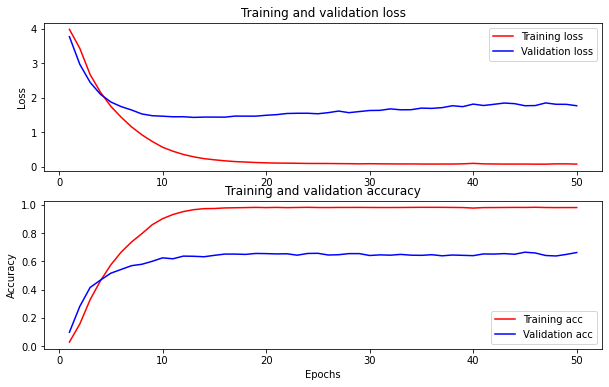

In [13]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [14]:
# classifier_model.save("behterin_model", include_optimizer=False)

In [15]:
# loaded_model = tf.keras.models.load_model('behterin_model')

In [ ]:
loaded_model = tf.keras.models.load_model('models/768/768_noDense_0.2Val_1Drop0.3_model-improvement-43-0.65')

In [ ]:
text_test = ['this is such an amazing movie!']
myTensor = tf.convert_to_tensor(text_test, dtype=tf.string)

###################################################################################################
###################################################################################################
# The model to get embbedings (intermediate_layer_model)

intermediate_layer_model = tf.keras.Model(inputs=loaded_model.get_layer("text").input,
                                       outputs=loaded_model.get_layer("BERT_encoder").output)
###################################################################################################
###################################################################################################


intermediate_layer_model.summary()

# Mydataset embbedings

In [17]:
import pandas as pd
import xlsxwriter
import numpy as np

In [18]:
data = pd.read_csv(r'C:\Users\MOHSEN-ASUS\JupyterProjects\bert classification (40-60)\bert_data_withoutClassWord.csv')

In [19]:
embbeding_size = 20

In [20]:
dataset_labels = np.array([])

In [21]:
dataset_empedings = np.zeros([1, embbeding_size])
dataset_labels = np.array([])
j = 0

for i in data["text"]:
    
    dataset_labels = np.append(dataset_labels, data["class"][j])
    
    txtTensor = tf.convert_to_tensor([i], dtype=tf.string)
    intermediate_output = intermediate_layer_model(txtTensor)
    
    sentence_embeding = intermediate_output.numpy()
    #print(sentence_embeding.shape)
    dataset_empedings = np.append(dataset_empedings, sentence_embeding, axis=0)
    
    j += 1


dataset_empedings = np.delete(dataset_empedings, 0, 0)

In [22]:
dataset_empedings.shape

(7115, 20)

In [23]:
dataset_labels.shape

(7115,)

# Embbedings view on T-SNE

In [24]:
from sklearn.manifold import TSNE
import seaborn as sns

In [25]:
x = dataset_empedings
y = dataset_labels 

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)

C:\Users\MOHSEN-ASUS\.conda\envs\piptext\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\MOHSEN-ASUS\.conda\envs\piptext\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7115 samples in 0.000s...
[t-SNE] Computed neighbors for 7115 samples in 1.996s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7115
[t-SNE] Computed conditional probabilities for sample 2000 / 7115
[t-SNE] Computed conditional probabilities for sample 3000 / 7115
[t-SNE] Computed conditional probabilities for sample 4000 / 7115
[t-SNE] Computed conditional probabilities for sample 5000 / 7115
[t-SNE] Computed conditional probabilities for sample 6000 / 7115
[t-SNE] Computed conditional probabilities for sample 7000 / 7115
[t-SNE] Computed conditional probabilities for sample 7115 / 7115
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.685879
[t-SNE] KL divergence after 1000 iterations: 0.841884


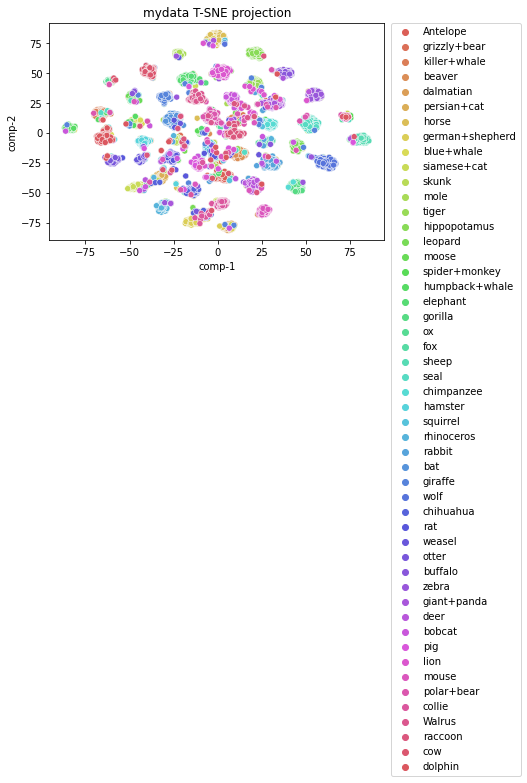

In [26]:
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 50),
                data=df).set(title="mydata T-SNE projection")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig('filename.png', dpi=500)

# TSNE for each class embbedings

In [104]:
import pandas as pd
import xlsxwriter
import numpy as np

data = pd.read_csv(r'C:\Users\MOHSEN-ASUS\JupyterProjects\bert classification\final_dataset_for_bert.csv')

In [111]:
def get_BERTembbedings(text, model):
    
    text_tensor = tf.convert_to_tensor(text, dtype=tf.string)
    model_output = model(text_tensor)
    
    return model_output["pooled_output"]

In [ ]:
def save_plot_TSNE(x, label, file_png):
    
    print(x.shape)
    print(label)
    
    y = np.array([])
    for i in x:
        y = np.append(y, label)
    
    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    z = tsne.fit_transform(x)
    
    df = pd.DataFrame()
    df["y"] = y
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]

    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                    palette=sns.color_palette("hls", 50),
                    data=df).set(title="mydata T-SNE projection")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    plt.savefig(file_png, dpi=300)

In [127]:
def TSNE_each_classEmbbeding(dataset, BERT, embbeding_size=768):
    
    # you should know the column name (in this case the name is "class") which has class values
    class_names = data["class"].unique()
    
    for i in class_names:
        
        # getting all of the texts belong to class i
        class_texts = dataset[dataset["class"] == i]
        
        # in the line below i am creating a zero array to append my embbedings to it (i dont know how to do it without creating a zero)
        class_texts_embbedings = np.zeros([1, embbeding_size])
        
        for j in class_texts:
            
            # obtaining embbedings of class i texts using "get_BERTembbedings" and appending them to an array
            class_texts_embbedings = np.append(get_BERTembbedings(j, BERT), class_texts_embbedings, axis=0)
        
        # deleting the zero array from the first row
        class_texts_embbedings = np.delete(class_texts_embbedings, 0, 0)
        
        # saving TSNE plot of each class embbedings
        save_plot_TSNE(class_texts_embbedings, i, i)
        

In [128]:
TSNE_each_classEmbbeding(data, intermediate_layer_model)

ValueError: Exception encountered when calling layer "preprocessing" (type KerasLayer).

Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (2 total):
    * Tensor("inputs:0", shape=(), dtype=string)
    * False
  Keyword arguments: {}

 Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (2 total):
    * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
    * False
  Keyword arguments: {}

Option 2:
  Positional arguments (2 total):
    * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
    * True
  Keyword arguments: {}

Call arguments received:
  • args=('tf.Tensor(shape=(), dtype=string)',)
  • kwargs={'training': 'False'}

In [113]:
class_names = data["class"].unique()
class_names.shape

(50,)

In [123]:
behnam = data[data["class"] == class_names[0]]
label = behnam["class"][0]
print(label)
y = np.array([])
for i in behnam["text"]:
    y = np.append(y, label)
    
y.shape

Antelope


(59,)

# Test blocks

In [40]:
test_text = "behnam"
probs = loaded_model.predict([test_text])

In [42]:
print(probs)

[[9.8559868e-01 3.5122331e-04 2.4117078e-04 4.5487666e-04 9.1990281e-05
  3.6703621e-04 2.6911215e-04 8.9518646e-05 5.6429714e-04 1.1563933e-04
  2.2724384e-04 3.6333693e-04 6.1131787e-04 1.8161589e-04 4.4743231e-04
  2.6473208e-04 7.7458040e-05 3.5198613e-05 1.2694254e-03 4.7917501e-04
  1.1139001e-04 3.1529050e-04 5.9277413e-04 1.2952139e-04 4.4515467e-04
  1.2069105e-04 6.0655686e-05 4.8951019e-04 7.6888617e-05 1.5119322e-04
  3.9288410e-04 8.4487263e-05 6.0229190e-04 1.9582360e-04 4.5138022e-05
  6.7228073e-05 9.5488504e-05 6.8909238e-04 1.4111183e-04 3.5351730e-04
  2.3887304e-04 1.0730186e-04 4.8800441e-05 3.9194722e-04 7.1938754e-05
  2.6265942e-04 3.0520180e-04 1.2587366e-04 6.4275716e-04 5.4395752e-04]]


In [10]:
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

NameError: name 'epochs' is not defined

In [ ]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)

In [ ]:
# original optimizer
####################################################################################
# steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
# num_train_steps = steps_per_epoch * epochs
# num_warmup_steps = int(0.1*num_train_steps)

# init_lr = 3e-5
# optimizer = optimization.create_optimizer(init_lr=init_lr,
#                                           num_train_steps=num_train_steps,
#                                           num_warmup_steps=num_warmup_steps,
#                                           optimizer_type='adamw')
####################################################################################